# Results of white-box MIAs on the CIFAR10 dataset

The models are trained using a CNN architecture referred to as CNN4 in the paper. 

The specification of this architecture is given in ```../configs/cifar10/cnn-large.ini```.

We load results for MIAs trained using different features (specified below as ```activations```, ```gradients```, or ```activations,gradients```), extracted from different layers (e.g., ```fc2``` which stands for the second fully connected layer). The features can be extracted from different types of shadow models, indicated in the ```attacker_accessess``` list below. We hope the naming to be self-explanatory. We refer you to ```shadow_modelling_attack.py``` for more details on the different types of shadow models. 

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.stats

In [2]:
attacker_accesses = ["aa-target_dataset",
    "aa-shadow_dataset_model_init",
    "aa-shadow_dataset",
    "aa-shadow_dataset-align-weight_sorting",
    "aa-shadow_dataset-align-bottom_up_weight_matching",
    "aa-shadow_dataset-align-bottom_up_activation_matching",
    "aa-shadow_dataset-align-top_down_weight_matching",
    "aa-shadow_dataset-align-bottom_up_correlation_matching",
    "aa-shadow_dataset_align_after_init",
    "aa-shadow_dataset-set-based"
]

In [3]:
roc_results = {attacker_access: 
               {f : defaultdict(list) 
                for f in ['activations', 'gradients', 'activations,gradients']} 
               for attacker_access in attacker_accesses}

In [8]:
experiments_dir = '../experiments/cifar10/attack/cnn-large/attack_results'
num_repetitions = 10

for features in ['activations', 'gradients']:
    print(f'\nFeatures: {features} \n')

    if features == "activations":
        target_layers = ["fc2", "fc2-ia", "fc2-ia-only", "fc1"]
    elif features == 'gradients':
        target_layers = ["fc2", "fc1", "conv2", "conv1"]

    for attacker_access in attacker_accesses:
        print(f'\nAttacker access: {attacker_access}')
        results = {layer: {"test_acc": [], "test_auc": [], "best_test_acc": []} for layer in target_layers}

        for layer in target_layers:
            num_repetitions_found = 0
            for exp in range(num_repetitions):
                result_dir = os.path.join(experiments_dir, attacker_access, features, layer)
                saved_model_path = os.path.join(result_dir, f'exp_{exp}_model.pickle')
                if not os.path.exists(saved_model_path):
                    continue
                with open(saved_model_path, 'rb') as f:
                    saved_model = pickle.load(f)
                    if not saved_model['train_complete']:
                        continue
                    test_metrics = saved_model['test_metrics']
                test_acc = test_metrics['acc']
                test_auc = test_metrics['auc']
                results[layer]['test_auc'].append(test_auc)
                results[layer]['test_acc'].append(test_acc)
                roc_results[attacker_access][features][layer].append( 
                    (test_metrics['fpr'], test_metrics['tpr']) )
                num_repetitions_found += 1
            if num_repetitions_found == 0:
                continue
            mean_test_auc, std_test_auc = np.mean(results[layer]['test_auc']), np.std(results[layer]['test_auc'])
            mean_test_acc, std_test_acc = np.mean(results[layer]['test_acc']), np.std(results[layer]['test_acc'])
            #print(results[layer]['test_auc'])
            h_test_auc =  std_test_auc * scipy.stats.t.ppf((1 + 0.95) / 2., num_repetitions_found-1) / (num_repetitions_found**0.5)
            print(f'Layer {layer}: {num_repetitions_found} experiments. ', 
                f'Test auc {mean_test_auc:.3f} ({h_test_auc:.3f}), test acc: {mean_test_acc:.1%} ({std_test_acc:.1%})')


Features: activations 


Attacker access: aa-target_dataset
Layer fc2: 10 experiments.  Test auc 0.816 (0.010), test acc: 76.0% (1.4%)
Layer fc2-ia: 10 experiments.  Test auc 0.846 (0.010), test acc: 76.6% (1.3%)
Layer fc1: 10 experiments.  Test auc 0.805 (0.014), test acc: 72.6% (1.8%)

Attacker access: aa-shadow_dataset_model_init
Layer fc2: 10 experiments.  Test auc 0.810 (0.011), test acc: 75.4% (1.3%)
Layer fc2-ia: 10 experiments.  Test auc 0.844 (0.013), test acc: 76.9% (1.5%)
Layer fc1: 10 experiments.  Test auc 0.750 (0.012), test acc: 68.6% (1.4%)

Attacker access: aa-shadow_dataset
Layer fc2: 10 experiments.  Test auc 0.815 (0.011), test acc: 75.7% (1.6%)
Layer fc2-ia: 10 experiments.  Test auc 0.825 (0.010), test acc: 76.1% (1.2%)
Layer fc2-ia-only: 10 experiments.  Test auc 0.726 (0.006), test acc: 66.8% (0.5%)
Layer fc1: 10 experiments.  Test auc 0.509 (0.005), test acc: 50.4% (0.6%)

Attacker access: aa-shadow_dataset-align-weight_sorting
Layer fc2: 10 experiments.  Test

In [10]:
features = 'activations,gradients'
print(f'\nFeatures: {features} \n')

target_layers = ["fc2-ia", "fc2", "fc2-ia,fc1", "fc2-ia,fc1,conv2,conv1"]

for attacker_access in attacker_accesses:
    print(f'\nAttacker access: {attacker_access}')
    results = {layer: {"test_acc": [], "test_auc": [], "best_test_acc": []} for layer in target_layers}

    for layer in target_layers:
        num_repetitions_found = 0
        for exp in range(num_repetitions):
            result_dir = os.path.join(experiments_dir, attacker_access, features, layer)
            saved_model_path = os.path.join(result_dir, f'exp_{exp}_model.pickle')
            if not os.path.exists(saved_model_path):
                continue
            with open(saved_model_path, 'rb') as f:
                saved_model = pickle.load(f)
                if not saved_model['train_complete']:
                    continue
                test_metrics = saved_model['test_metrics']
            test_acc = test_metrics['best_acc']
            test_auc = test_metrics['auc']
            results[layer]['test_auc'].append(test_auc)
            results[layer]['test_acc'].append(test_acc)
            num_repetitions_found += 1
            roc_results[attacker_access][features][layer].append( 
                    (test_metrics['fpr'], test_metrics['tpr']) )
        if num_repetitions_found == 0:
            continue
        mean_test_auc, std_test_auc = np.mean(results[layer]['test_auc']), np.std(results[layer]['test_auc'])
        mean_test_acc, std_test_acc = np.mean(results[layer]['test_acc']), np.std(results[layer]['test_acc'])
        h_test_auc =  std_test_auc * scipy.stats.t.ppf((1 + 0.95) / 2., num_repetitions_found-1) / (num_repetitions_found**0.5)
        print(f'Layer {layer}: {num_repetitions_found} experiments. ', 
            f'Test auc {mean_test_auc:.3f} ({h_test_auc:.3f}), best test acc: {mean_test_acc:.1%} ({std_test_acc:.1%})')


Features: activations,gradients 


Attacker access: aa-target_dataset
Layer fc2-ia: 10 experiments.  Test auc 0.860 (0.013), best test acc: 78.2% (1.6%)
Layer fc2: 10 experiments.  Test auc 0.839 (0.012), best test acc: 77.7% (1.6%)
Layer fc2-ia,fc1: 10 experiments.  Test auc 0.857 (0.014), best test acc: 77.9% (1.7%)
Layer fc2-ia,fc1,conv2,conv1: 10 experiments.  Test auc 0.853 (0.015), best test acc: 77.8% (2.0%)

Attacker access: aa-shadow_dataset_model_init
Layer fc2-ia: 10 experiments.  Test auc 0.857 (0.013), best test acc: 78.4% (1.6%)
Layer fc2: 10 experiments.  Test auc 0.829 (0.014), best test acc: 76.9% (1.8%)
Layer fc2-ia,fc1: 10 experiments.  Test auc 0.859 (0.019), best test acc: 78.5% (2.4%)
Layer fc2-ia,fc1,conv2,conv1: 10 experiments.  Test auc 0.862 (0.018), best test acc: 78.5% (2.4%)

Attacker access: aa-shadow_dataset
Layer fc2-ia: 10 experiments.  Test auc 0.837 (0.014), best test acc: 77.4% (1.9%)
Layer fc2: 10 experiments.  Test auc 0.822 (0.016), best test acc

# ROC curve

(S3) Black-box 0.07224
(S2) White-box + same initiali-
sation 0.13264000000000004
(S3) White-box + no re-alignment 0.07831999999999999
(S4) White-box + weight
 sorting 0.07752
(S5) White-box + bottom-up 
weight re-alignment 0.12111999999999998
(S6) White-box + top-down 
weight re-alignment 0.10336000000000002
(S7) White-box + activation 
re-alignment 0.12339999999999997
(S8) White-box + correlation 
re-alignment 0.12184


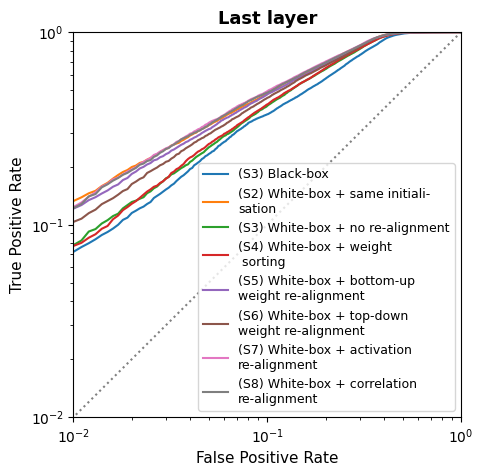

(S3) Black-box 0.07224
(S2) White-box + same initiali-
sation 0.12639999999999996
(S3) White-box + no re-alignment 0.08120000000000001
(S4) White-box + weight
 sorting 0.07996
(S5) White-box + bottom-up 
weight re-alignment 0.10776000000000001
(S6) White-box + top-down 
weight re-alignment 0.11276000000000003
(S7) White-box + activation 
re-alignment 0.13871999999999998
(S8) White-box + correlation 
re-alignment 0.1212


In [ ]:
from confidence_interval import ci_roc_curve

for white_box_layers, title in [('fc2-ia', 'Last layer'), ('fc2-ia,fc1', 'Last two layers')]:

    attacks = [('aa-shadow_dataset', 'activations', 'fc2', 
            '(S3) Black-box'), 
        ('aa-shadow_dataset_model_init', 'activations,gradients', white_box_layers, 
         '(S2) White-box + same initiali-\nsation'),
        ('aa-shadow_dataset', 'activations,gradients', white_box_layers, 
         '(S3) White-box + no re-alignment'),
        ('aa-shadow_dataset-align-weight_sorting', 'activations,gradients', white_box_layers, 
         '(S4) White-box + weight\n sorting'),
        ('aa-shadow_dataset-align-bottom_up_weight_matching', 'activations,gradients', white_box_layers, 
         '(S5) White-box + bottom-up \nweight re-alignment'),
        ('aa-shadow_dataset-align-top_down_weight_matching', 'activations,gradients', white_box_layers, 
         '(S6) White-box + top-down \nweight re-alignment'),
        ('aa-shadow_dataset-align-bottom_up_activation_matching', 'activations,gradients', white_box_layers, 
         '(S7) White-box + activation \nre-alignment'),
        ('aa-shadow_dataset-align-bottom_up_correlation_matching', 'activations,gradients', white_box_layers, 
         '(S8) White-box + correlation \nre-alignment')]
    base_fpr = np.linspace(0, 1, 1001)

    fig, ax = plt.subplots(figsize=(5, 5))

    for attack in attacks:
        attacker_access, features, layers, label = attack
        fprs, tprs = zip(*roc_results[attacker_access][features][layers])
        mean_tpr, lower_tpr, upper_tpr = ci_roc_curve(fprs, tprs, base_fpr)
        ax.plot(base_fpr, mean_tpr, label=label)
        i = 0 
        while i < len(base_fpr):
            if base_fpr[i] >= 0.01:
                print(label, mean_tpr[i])
                break
            i += 1

    ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='gray', ls=':')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-2, 1)
    ax.set_ylim(1e-2, 1)
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.legend(fontsize=9, loc='lower right')
    plt.title(title, fontweight='bold', fontsize=13)
    plt.savefig(f'../notebooks/plots/roc_cifar10_{white_box_layers}.pdf', bbox_inches='tight')
    plt.show()
    plt.close()